### 목표: 주어진 시작 및 종료 좌표에 따라 테스트 데이터 세트에서 각 주행 기간을 예측하여 어떤 경로를 택하는 것이 가장 좋은지 알기 위함

## 필요한 라이브러리 설치 및 로드

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

## 데이터 로드 및 확인

In [24]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv("sample_submission.csv")

train.shape, test.shape

((1458644, 11), (625134, 9))

변수설명

* id: 각 여행에 대한 식별자  
* vendor_id: 여행 기록과 관련된 제공자를 나타내는 코드  
* pickup_datetime: 미터가 작동 된 날짜 및 시간  
* dropoff_datetime: 미터가 작동되지 않은 날짜 및 시간  
* passenger_count: 차량의 승객수 (운전자 입력 값)  
* pickup_latitude: 미터가 사용 된 경도  
* pickup_longtitude: 미터가 사용된 위도  
* dropoff_longtitude: 미터가 사용 안 된 경도  
* dropoff_latitude: 미터가 사용 안 된 위도  
* stor_and_fwd_flag: 차량이 서버에 연결되어 있지 않기 때문에 공급 업체에 보내기 전에 여행 레코드가 차량 메모리에 보유되었는지 여부를 나타냄:(Y=저장 및 전달, N=저장 및 전달 여행이 아님)  
* trip_duration: 여행 시간(초)

In [25]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
display(train.head())
display(train.describe())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


최소 1초 탄 사람도 있고 최대 3526282초(약 980시간)탄 사람도 있을 것인데.. 그럴 리가 없다. -> 이런 특이점들을 처리해줘야함

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


id가 굳이 필요할까? vendor_id: 노점상 번호가 필요한가? 

데이터에 결측치는 보이지 않음 결측치를 처리해줄 필요가 다행히 없는것으로

## 데이터 전처리

pickup_datetime 에서 시간, 날짜, 월을 추출해야된다  
-> 피크시간대의 교통량 / 주말과 주말이 아닌 날 => 이동에 영향을 미칠 수 있는 요인

여행의 계절성 => 뉴욕의 겨울.. 도로가 젖어있거나 얼음이 얼면 빠르게 운전할 가능성이 낮기 때문에 어떤 경로를 택하든 목적지에 도달하는데 시간이 더 걸릴 것으로 파악

passenger_count 승객의 수가 증가하면 생기는 변수.  
1) 중간에 정차하는 정류장이 증가하여 시간이 연장될 수 있음  
2) 혹은 승객이 많아서 차가 무거울 수록 차의 이동속도가 느려질 수도 있을 것이라 생각.  

vendor와 store_and_fwd_flag는 잘 모르겠다.

여기서 제일 가치 있는 컬럼은 latitude와 longtitude 일 것이다. 



In [27]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
display(train.head())
display(train.info())

# object인 datetime을 date-time object로 변환시켜준다

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


None

In [28]:
train[pd.isnull(train)].sum() #결측치는 없는 것으로 확인된다.

id                    0   
vendor_id            0.000
passenger_count      0.000
pickup_longitude     0.000
pickup_latitude      0.000
dropoff_longitude    0.000
dropoff_latitude     0.000
store_and_fwd_flag    0   
trip_duration        0.000
dtype: object

이 dataset의 기간은 어느정도 일까? 첫 날짜부터, 마지막 날짜를 구해보자

In [29]:
train[pd.isnull(train)].sum()
### dataset의 길이
print("Min pickup time:", min(train['pickup_datetime']))
print("Max pickup time:", max(train['pickup_datetime']))

Min pickup time: 2016-01-01 00:00:17
Max pickup time: 2016-06-30 23:59:39


거의 6개월 정도 기간의 데이터이다

pickup_datetime 에서 시간, 날짜, 월을 추출해야된다  
-> 피크시간대의 교통량 / 주말과 주말이 아닌 날 => 이동에 영향을 미칠 수 있는 요인

In [30]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].apply(lambda x:x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x:x.hour)
train['pickup_day_of_week'] = train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].apply(lambda x:x.day)
train['dropoff_hour'] = train['dropoff_datetime'].apply(lambda x:x.hour)
train['dropoff_day_of_week'] = train['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

In [31]:
## 위도 경도 변수 소수점 이하 3자리까지 반올림
train['pickup_latitude_round3']=train['pickup_latitude'].apply(lambda x:round(x,3))
train['pickup_longitude_round3']=train['pickup_longitude'].apply(lambda x:round(x,3))
train['dropoff_latitude_round3']=train['dropoff_latitude'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3']=train['dropoff_longitude'].apply(lambda x:round(x,3))

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,...,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,...,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,...,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,...,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,...,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


여정의 거리를 위도와 경도를 바탕으로 km단위로 구해보자

In [32]:
#haversine 공식은 경도와 위도를 고려하여 구의 두 점 사이의 원거리를 결정합니다
def calculateDistance(row):
    R=6376.0 # 지구의 대략적인 반경(km)
    pickup_lat = radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    dlon = dropoff_lon -pickup_lon
    dlat = dropoff_lat -pickup_lat
    
    a=sin(dlat /2) **2 +cos(pickup_lat)*cos(dropoff_lat)*sin(dlon/2)**2
    c=2*atan2(sqrt(a), sqrt(1-a))
    distance=R*c
    return distance

In [33]:
train['trip_distance'] = train.apply(lambda row:calculateDistance(row), axis=1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,...,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.500
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,...,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.807
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,...,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.390
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,...,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.487
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,...,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.190


In [34]:
train['trip_duration_in_hour']=train['trip_duration'].apply(lambda x:x/3600)
train.head()
#시간당 여정 지속 시간

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,...,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.500,0.126
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,...,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.807,0.184
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,...,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.390,0.590
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,...,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.487,0.119
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,...,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.190,0.121


## EDA

Text(0.5, 0, 'Trip Duration (in hour)')

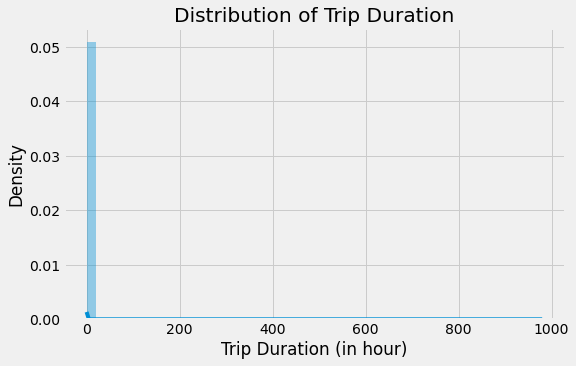

In [35]:
plt.figure(figsize=(8,5))
sns.distplot(train['trip_duration_in_hour']).set_title("Distribution of Trip Duration")
plt.xlabel("Trip Duration (in hour)")
#이 그래프가 의미하는 바를 모르겠네?

In [36]:
# 24시간 보다 더 긴 시간 여행한 컬럼 생성. 우리는 여기에다가 집중할 것이다.
outlier_trip_duration = train.loc[train['trip_duration_in_hour']>24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.790,40.644,-73.957,40.773,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.164,538.816
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.922,40.735,-73.985,40.760,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.987,569.327
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.984,40.742,-73.985,40.728,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.636,618.781
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.784,40.649,-73.978,40.750,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.916,979.523


In [37]:
train['trip_duration'].sort_values(ascending=False)
#최대 3526282초
#최소 1초
#말이 안된다고 생각

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291    86392  
           ...    
269418     1      
467645     1      
533799     1      
726971     1      
311745     1      
Name: trip_duration, Length: 1458644, dtype: int64

Text(0.5, 1.0, 'Disribution of trip duration (sec) in Log Scale')

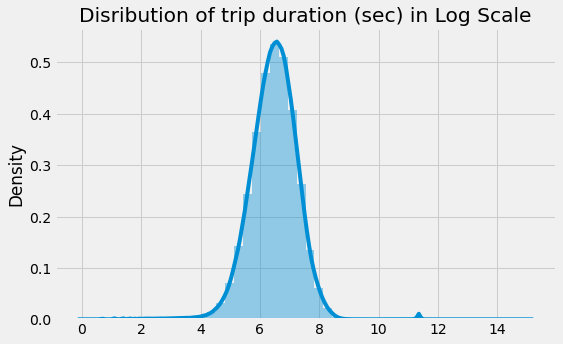

In [38]:
"""
주행 기간이 매우 높은 4개의 기록이 있지만 주행 거리는 매우 낮다. 이것들은 특이치 입니다. 
하지만 이 여행들이 시작되거나 끝나는 특별한 장소가 있을까? 트립 지속시간도 편향되어 있으니 로그 변환을 해보자.
이러한 데이터도 테스트 데이터의 일부일 수 있으므로 분석에서 제거하지 않을 것이다.
"""


plt.figure(figsize=(8,5))
sns.distplot(np.log(train['trip_duration'].values)).set_title("Distribution of Trip Duration")
plt.title("Disribution of trip duration (sec) in Log Scale")

In [39]:

# 여행 지속시간의 로그 변환은 정규 분포를 따른다. 
# 대부분의 여행은 54초(4)에서 2980초(8) 사이에 있다. 
# 이것은 대부분의 여행이 한 시간 동안 함께 한다는 것을 나타낸다. 
# 그러나 1분도 안 되는 여행이 있어 자세히 살펴볼 필요가 있다. 
# 100시간 동안 지속되는 여행이 있는데, 택시 타기가 뉴욕 안에 있어서 이상하다.

승차와 하차가 어디서 일어나는지 위치를 표시

### 1. 지역

In [40]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id' : 'Num_Trips'})
pickup.head()

,pickup_latitude_round3,pickup_longitude_round3,Num_Trips
0,34.360,-65.848,1
1,34.712,-75.354,1
2,35.082,-71.800,1
3,35.310,-72.074,1
4,36.029,-77.441,1


In [41]:
pickup_map = folium.Map(location=[40.730610, -73.935242], zoom_start=10,)
# print (pickup.shape)
pickup.Num_Trips.values
pickup.Num_Trips = np.array(pickup.Num_Trips.values).astype('float64')
hm_wide = HeatMap(list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Num_Trips.values)),
                 min_opacity=0.2,
                 radius = 15, blur =15,
                 max_zoom=1)

pickup_map.add_child(hm_wide)
pickup_map 

(-74.03, -73.75)

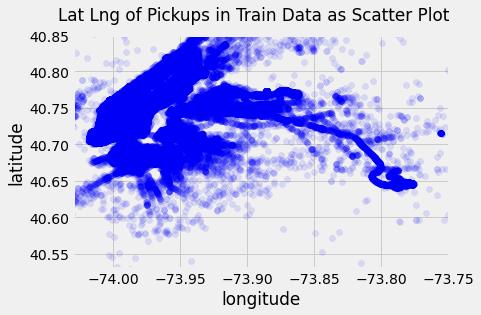

In [42]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.53, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'], color='blue', label='train', alpha=0.1)
fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

위 그래프는 존 에프 케네디 공항에서 높은 밀도로 픽업을 진행한다는 것을 보여준다

(-74.03, -73.75)

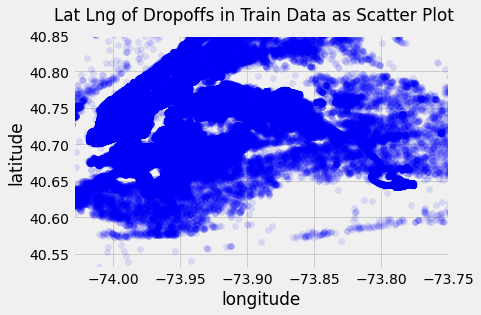

In [43]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.53, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['dropoff_longitude'], train['dropoff_latitude'], color='blue', label='train', alpha=0.1)
fig.suptitle('Lat Lng of Dropoffs in Train Data as Scatter Plot')
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

Dropoff 

In [44]:
drop=train.groupby(['dropoff_latitude_round3','dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [45]:
drop_map = folium.Map(location=[40.730610, -73.935242], zoom_start=10,)
hm_wide = HeatMap(list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, drop.Num_Trips)),
                 min_opacity=0.2,
                 radius=20, blur=15,
                 max_zoom=1)
drop_map.add_child(hm_wide)
drop_map

Dropoff Heatmap은 Pickup과 유사하다.

Pickup

In [46]:
pickup= train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'Avg_Trip_duration'})

In [47]:
pickup_map = folium.Map(location= [40.730610, -73.935242], zoom_start=10,)
hm_wide = HeatMap(list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Avg_Trip_duration)),
                 min_opacity=0.2,
                 radius=20, blur=15,
                 max_zoom=1)
pickup_map.add_child(hm_wide)
pickup_map

즉 Trip이 JFK에서 시작할 때 가장 높다
이 곳으로부터의 픽업은 높은 여행 시간을 가지는 경향이 있음

### 2. 시간, 요일

어느시간대가 pickup, dropoff이 높은지 확인

Text(0.5, 1.0, 'Pick Hours Distribution')

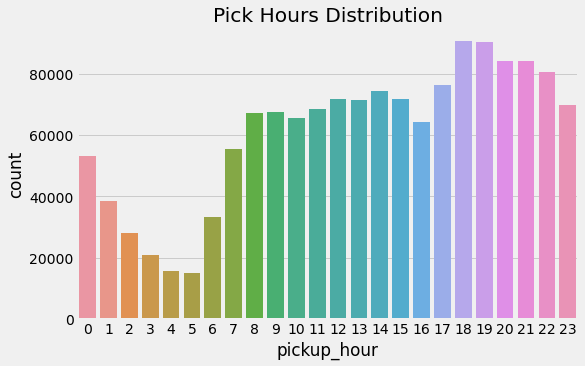

In [48]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_hour']).set_title("Pick Hours Distribution")

dropoff도 거의 비슷한 그래프를 그리고 있다

Text(0.5, 1.0, 'Dropoff Hours Distribution')

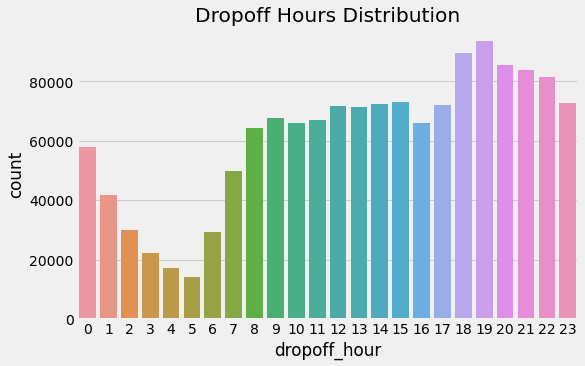

In [49]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['dropoff_hour']).set_title("Dropoff Hours Distribution")

전체 pickup 시간대 분포

Text(0.5, 1.0, 'Distribution of Pickups over time')

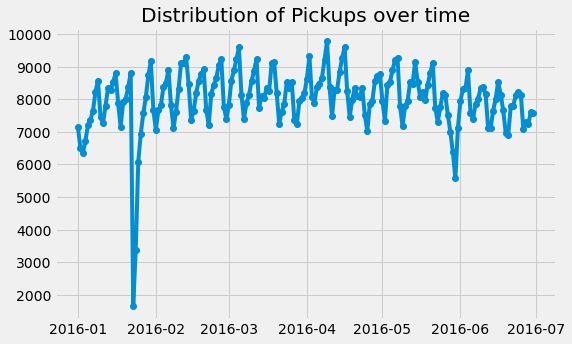

In [50]:
plt.figure(figsize=(8,5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.title("Distribution of Pickups over time")
#2016년 2월을 끝으로 pickup의 숫자는 떨어지는 것으로 보인다.

trip기간이 긴 시간대는?

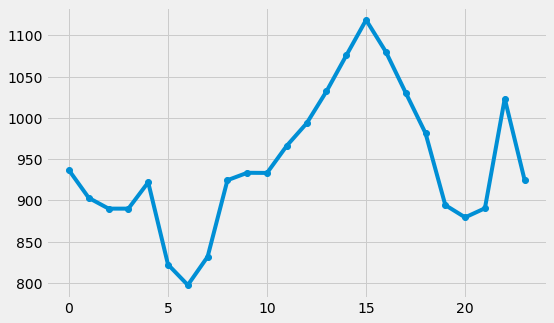

In [51]:
avg_duration_hour = train.groupby(['pickup_hour'])['trip_duration'].mean()
plt.figure(figsize=(8,5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(), 'o-')
#10~15시간대 사이가 duration이 증가한다.

요일별 pickup

<AxesSubplot:xlabel='pickup_day_of_week', ylabel='count'>

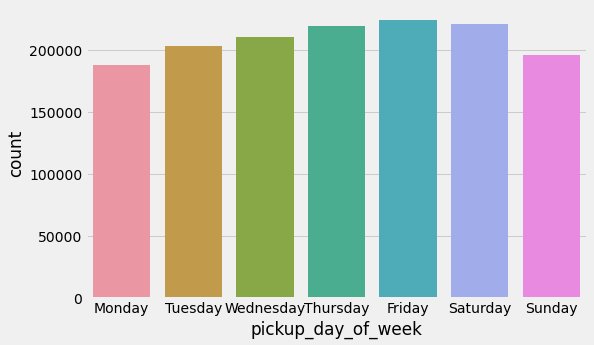

In [52]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_day_of_week'],
              order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'
                    , 'Saturday', 'Sunday'])
#pickup 비율은 월요일이 제일 낮고, 화요일부터 증가하다가 금요일이 제일 높다.

요일별 평균 Trip 기간

In [53]:
avg_duration_day = train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration' : 'avg_trip_duration'})

Text(0.5, 1.0, 'Avg Trip Duration vs Pickup Days of Week')

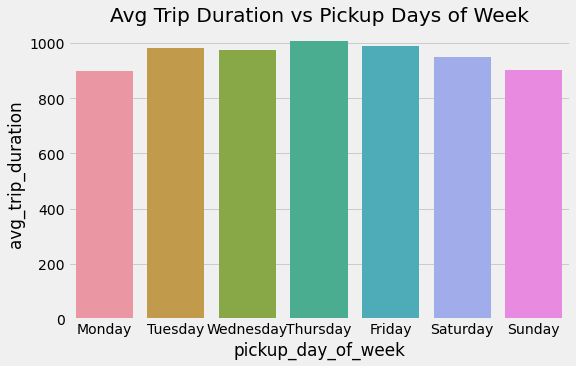

In [54]:
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week',
            y='avg_trip_duration', 
            data=avg_duration_day, 
            order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Trip Duration vs Pickup Days of Week")
#목요일이 제일 높다

### 3) 거리, 지역, 속도

In [55]:
train['trip_distance'].head()

0   1.500
1   1.807
2   6.390
3   1.487
4   1.190
Name: trip_distance, dtype: float64

In [56]:
train['trip_duration'].head()

0    455 
1    663 
2    2124
3    429 
4    435 
Name: trip_duration, dtype: int64

In [57]:
# plt.figure(figsize=(8,5))
# sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
# sns.distplot(np.log(train['trip_distance'].values)).set_title("Distribution of Trip Duration") # cannot convert float infinity to integer
# sns.distplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
# plt.xlabel("Trip Distance (log)")

trip duration VS trip distance 비교

Text(0, 0.5, 'Trip Duration (log scale)')

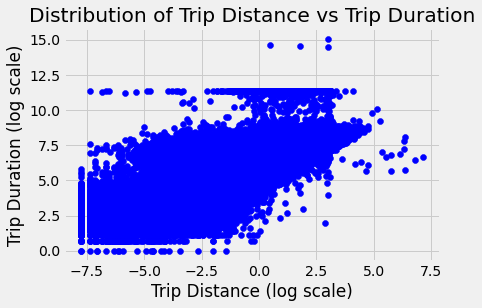

In [58]:
plt.scatter(np.log(train['trip_distance'].values),
            np.log(train['trip_duration'].values),
            color='blue', label='train'
            )
plt.title("Distribution of Trip Distance vs Trip Duration")
plt.xlabel("Trip Distance (log scale)")
plt.ylabel("Trip Duration (log scale)")

여행 방향을 측정

In [59]:
 def calculateBearing(lat1, lng1, lat2, lng2):
        R=6371
        lng_delta_rad = np.radians(lng2-lng1)
        lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
        y = np.sin(lng_delta_rad) * np.cos(lat2)
        x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
        return np.degrees(np.arctan2(y, x))   
        

In [60]:
train['bearing'] = train.apply(lambda row : calculateBearing(row['pickup_latitude_round3'], row['pickup_longitude_round3'], row['dropoff_latitude_round3'], row['dropoff_longitude_round3']), axis=1)
# train['bearing'] = train.apply(lambda row : calculateBearing(row['pickup_latitude_round3'], row['pickup_longitude_round3'], row['dropoff_latitude_round3'], row['dropoff_longitude_round3']),axis=1)

bearing 분포

<AxesSubplot:xlabel='bearing', ylabel='Density'>

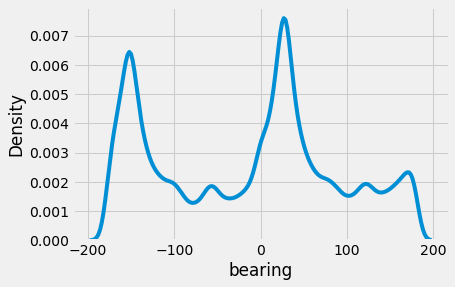

In [61]:
sns.kdeplot(train['bearing'])

Bearing VS Trip Duration

Text(0, 0.5, 'Trip Duration (log scale)')

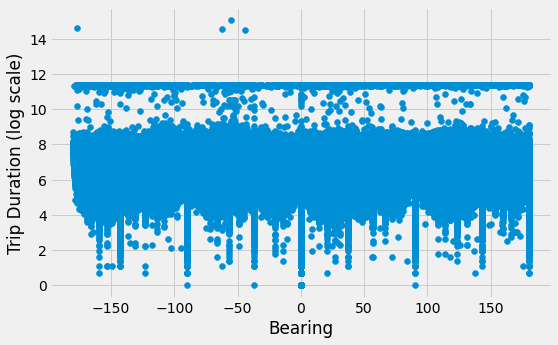

In [62]:
plt.figure(figsize=(8,5))
plt.scatter(train['bearing'].values, y=np.log(train['trip_duration'].values))
plt.xlabel("Bearing")
plt.ylabel("Trip Duration (log scale)")
#outlier가 보임

In [63]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y    8045   
Name: store_and_fwd_flag, dtype: int64

Text(0, 0.5, 'Destiny')

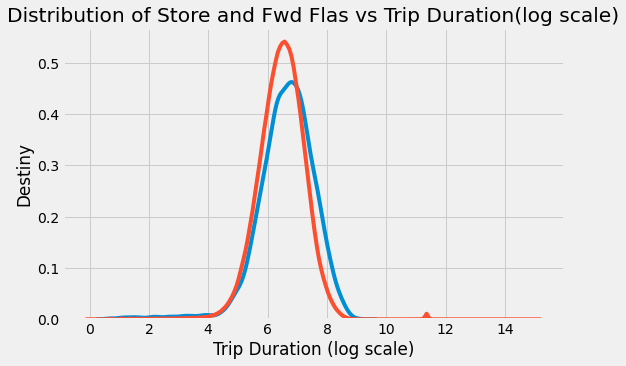

In [64]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='Y', 'trip_duration'].values), label='Store and Fwd = Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='N', 'trip_duration'].values), label='Store and Fwd = No')

plt.title("Distribution of Store and Fwd Flas vs Trip Duration(log scale)")
plt.xlabel('Trip Duration (log scale)')
plt.ylabel('Destiny')

In [65]:
coords = np.vstack((train[['pickup_latitude','pickup_longitude']].values,
                   train[['dropoff_latitude','dropoff_longitude']].values,
                   test[['pickup_latitude','pickup_longitude']].values,
                   test[['dropoff_latitude','dropoff_longitude']].values))
kmeans = KMeans(n_clusters=8, random_state=0).fit(coords)

(-74.03, -73.75)

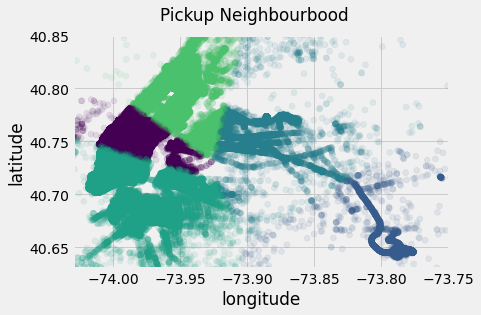

In [66]:
train.loc[:, 'pickup_neighbourhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
          c=train['pickup_neighbourhood'], label='train', alpha=0.1)

fig.suptitle('Pickup Neighbourbood')
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

Text(0.5, 1.0, 'Distribution of Number of Pickups across Neighbourhood')

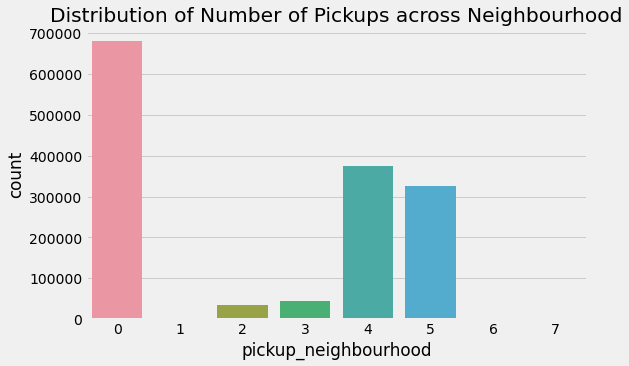

In [67]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_neighbourhood']).set_title("Distribution of Number of Pickups across Neighbourhood")

Text(0.5, 1.0, 'Avg Trip Duration vs Neighbourhood')

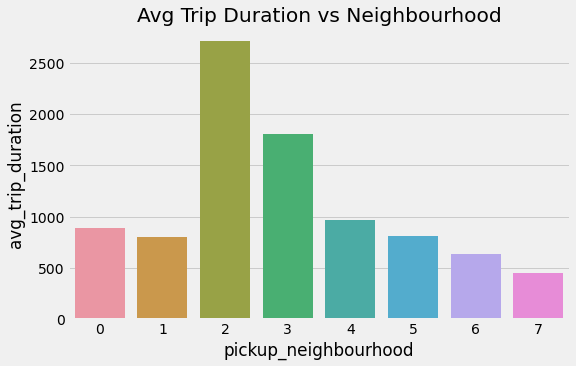

In [68]:
avg_duration_neighbourhood = train.groupby(['pickup_neighbourhood'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_neighbourhood', y='avg_trip_duration', data=avg_duration_neighbourhood).set_title("Avg Trip Duration vs Neighbourhood")

Text(0.5, 1.0, 'Distribution of Average Speed (in kph)')

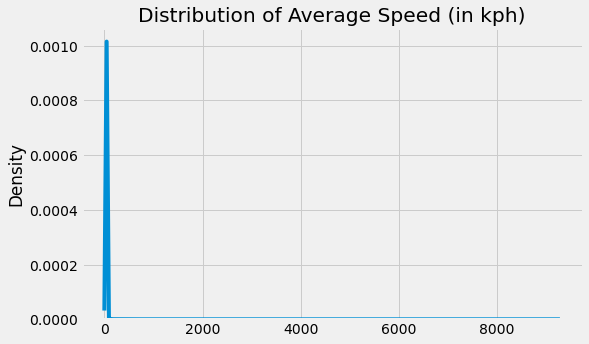

In [69]:
train['avg_speed_kph'] = train['trip_distance'] / train['trip_duration_in_hour']
plt.figure(figsize=(8,5))
sns.kdeplot(train['avg_speed_kph'].values).set_title("Distribution of Average Speed (in kph)")

In [70]:
print("Average speed is", np.mean(train['avg_speed_kph']), "kph")

Average speed is 14.434528392345554 kph


Text(0.5, 1.0, 'Avg Speed (kph) vs Pickup Days of Week')

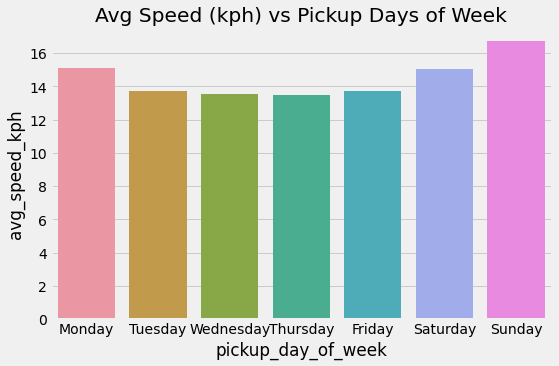

In [71]:
avg_speed_per_day = train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week', y='avg_speed_kph', data=avg_speed_per_day, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Speed (kph) vs Pickup Days of Week")

In [72]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_day'] = test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour'] = test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week'] = test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

test['pickup_latitude_round3']=test['pickup_latitude'].apply(lambda x:round(x,3))
test['pickup_longitude_round3']=test['pickup_longitude'].apply(lambda x:round(x,3))
test['dropoff_latitude_round3']=test['dropoff_latitude'].apply(lambda x:round(x,3))
test['dropoff_longitude_round3']=test['dropoff_longitude'].apply(lambda x:round(x,3))
test['trip_distance'] = test.apply(lambda row : calculateDistance(row), axis=1)

test['bearing']=test.apply(lambda row:calculateBearing(row['pickup_latitude_round3'], 
                                                       row['pickup_longitude_round3'], row['dropoff_latitude_round3'], row['dropoff_longitude_round3']), axis=1)
test.loc[:,'pickup_neighbourhood'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:,'dropoff_neighbourhood'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [73]:
drop_cols=['avg_speed_kph','trip_duration_in_hour','dropoff_date','dropoff_day','dropoff_hour','dropoff_day_of_week','dropoff_datetime','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
training = train.drop(drop_cols, axis=1)
testing=test.drop(['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'], axis=1)

In [74]:
training

,id,vendor_id,pickup_datetime,passenger_count,store_and_fwd_flag,trip_duration,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,bearing,pickup_neighbourhood,dropoff_neighbourhood
0,id2875421,2,2016-03-14 17:24:55,1,N,455,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.500,98.824,0,5
1,id2377394,1,2016-06-12 00:43:35,1,N,663,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.807,-119.054,0,4
2,id3858529,2,2016-01-19 11:35:24,1,N,2124,2016-01-19,19,11,Tuesday,40.764,-73.979,40.710,-74.005,6.390,-159.948,0,4
3,id3504673,2,2016-04-06 19:32:31,1,N,429,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.487,-173.348,4,4
4,id2181028,2,2016-03-26 13:30:55,1,N,435,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.190,180.000,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,4,N,778,2016-04-08,8,13,Friday,40.746,-73.982,40.740,-73.995,1.226,-121.344,0,4
1458640,id1049543,1,2016-01-10 07:35:15,1,N,655,2016-01-10,10,7,Sunday,40.747,-74.001,40.797,-73.970,6.055,25.142,0,5
1458641,id2304944,2,2016-04-22 06:57:41,1,N,764,2016-04-22,22,6,Friday,40.769,-73.959,40.707,-74.004,7.831,-151.177,5,4
1458642,id2714485,1,2016-01-05 15:56:26,1,N,373,2016-01-05,5,15,Tuesday,40.749,-73.982,40.757,-73.975,1.093,33.536,0,0


In [75]:
training['log_trip_duration'] = training['trip_duration'].apply(lambda x : np.log(x))
training.drop(['trip_duration'], axis=1, inplace=True)

In [76]:
print("Training Data Shape", training.shape)
print("Testing Data Shape", testing.shape)

Training Data Shape (1458644, 18)
Testing Data Shape (625134, 17)


In [77]:
def encodeDay(day_of_week):
    day_dict = {'Sunday' :0, 'Monday':1, 'Tuesday':2 ,'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6}
    return day_dict[day_of_week]


In [78]:
training['pickup_day_of_week'] = training['pickup_day_of_week'].apply(lambda x:encodeDay(x))
testing['pickup_day_of_week'] = testing['pickup_day_of_week'].apply(lambda x:encodeDay(x))


In [79]:
training.to_csv("input_training.csv", index=False)
testing.to_csv("input_testing.csv", index=False)

del training
del testing
del train
del test

In [80]:
def LabelEncoding(train_df, test_df, max_levels=2):
    for col in train_df:
        if len(list(train_df[col].unique())) <= max_levels:
            le = preprocessing.LabelEncoder()
            le.fit(train_df[col])
            train_df[col] = le.transform(train_df[col])
            test_df[col] = le.transform(test_df[col])
    return [train_df, test_df]

def readInputAndEncode(input_path, train_file, test_file, target_column):
    training = pd.read_csv(input_path+train_file)
    testing = pd.read_csv(input_path+test_file)
    
    training, testing = LabelEncoding(training, testing)
    
    print("Training Data Shape after Encoding ", training.shape)
    print("Testing Data Shape after Encoding ", testing.shape)
    
    train_cols = training.columns.tolist()
    test_cols = testing.columns.tolist()
    col_in_train_not_test = set(train_cols) -set(test_cols)
    
    for col in col_in_train_not_test:
        if col!=target_column:
            testing[col] = 0
    col_in_test_not_train = set(test_cols) -set(train_cols)
    for col in col_in_test_not_train:
        training[col]=0
    print("---------------")
    print("Training Data Shape after Processing ", training.shape)
    print("Testing Data Shape after Processing ", testing.shape)
    
    return [training, testing]   
    

In [81]:
train, test = readInputAndEncode("", 'input_training.csv', 'input_testing.csv', 'log_trip_duration')
train.drop(['pickup_date'], axis=1, inplace=True)
test.drop(['pickup_date'], axis=1, inplace=True)
train.drop(['pickup_datetime'], axis=1, inplace=True)
test.drop(['pickup_datetime'], axis=1, inplace=True)
test_id = test['id']
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

Training Data Shape after Encoding  (1458644, 18)
Testing Data Shape after Encoding  (625134, 17)
---------------
Training Data Shape after Processing  (1458644, 18)
Testing Data Shape after Processing  (625134, 17)


In [82]:
def GetFeatureAndSplit(train, test, target, imputing_strategy='median', split=0.25, imputation=True ):
    labels=np.array(train[target])
    training = train.drop(target, axis=1)
    training = np.array(training)
    testing = np.array(test)
    
    if imputation == True:
        imputer = SimpleImputer(strategy=imputing_strategy, missing_values=np.nan)
        imputer.fit(training)
        training = imputer.transform(training)
        testing = imputer.transform(testing)
    
    train_features, validation_features, train_labels, validation_labels = train_test_split(training, labels, test_size= split, random_state=42)
    return [train_features, validation_features, train_labels, validation_labels, testing]

In [83]:
train_features, validation_features, train_labels, validation_labels, testing=GetFeatureAndSplit(train, test, 'log_trip_duration', imputation=True)

In [84]:
lm = linear_model.LinearRegression()
lm.fit(train_features, train_labels)

LinearRegression()

In [85]:
valid_pred = lm.predict(validation_features)

In [86]:
rmse = mean_squared_error(validation_labels, valid_pred)
print("Root Mean Squared Error for Linear Regression(log scale)", rmse)

Root Mean Squared Error for Linear Regression(log scale) 0.403117624968816


In [87]:
test_pred = lm.predict(testing)
submit= pd.DataFrame()
submit['id'] = test_id
submit['trip_duration'] = np.exp(test_pred)
submit.to_csv("submission_linear_regression_baseline.csv", index = False)

In [88]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train_features, train_labels)

RandomForestRegressor(random_state=42)

In [89]:
valid_pred_rf= rf.predict(validation_features)
rmse=mean_squared_error(validation_labels, valid_pred_rf)
print("Root Mean Squared Error for Random Forest", rmse)

Root Mean Squared Error for Random Forest 0.16587895972045769


In [90]:
test_pred=rf.predict(testing)
submit=pd.DataFrame()
submit['id']=test_id
submit['trip_duration']=np.exp(test_pred)
submit.to_csv("submission_random_forest_baseline.csv",index=False)